In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Aug  7 00:30:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [8]:
import os
import cv2
import yaml
import json
import torch
import base64
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from pathlib import Path

# 랜덤성 제어
random_seed = 2022
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False

torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU

In [9]:
class AttrDict(dict):
  def __init__(self, *args, **kwargs):
    super(AttrDict, self).__init__(*args, **kwargs)
    self.__dict__ = self


config = AttrDict()

# training option
config.lr = 0.0001
config.epochs = 30
config.patient = 5
config.batch_size = 4
config.num_workers = 2
config.num_efficientnet = 7
config.cuda = 'cuda' if torch.cuda.is_available() else 'cpu'

# image size
config.img_width = 224
config.img_height = 224

# stratify option
config.n_splits = 5
config.shuffle = True

# seed
config.random_state = 1656

In [10]:
from glob import glob


# 능성어 data frame 생성, label = 0
# 바리과 data frame 생성, label = 1
# 유사어종 data frame 생성, label = 2
# 자바리 data frame 생성, label = 3

train_data1 = glob(f'/content/drive/MyDrive/해양/어종분류/능성어/*')
train_data2 = glob(f'/content/drive/MyDrive/해양/어종분류/유사어종/*')
train_data3 = glob(f'/content/drive/MyDrive/해양/어종분류/유사어종 외/*')
train_data4 = glob(f'/content/drive/MyDrive/해양/어종분류/자바리/*')
len(train_data1),len(train_data2),len(train_data3),len(train_data4)

train_label1 = [0] * len(train_data1)
train_label2 = [1] * len(train_data2)
train_label3 = [2] * len(train_data3)
train_label4 = [3] * len(train_data4)

df1 = pd.DataFrame({
    'path':train_data1,
    'label':train_label1
})
df2 = pd.DataFrame({
    'path':train_data2,
    'label':train_label2
})
df3 = pd.DataFrame({
    'path':train_data3,
    'label':train_label3
})
df4 = pd.DataFrame({
    'path':train_data4,
    'label':train_label4
})

print(len(train_label1), len(train_label2),len(train_label3),len(train_label4))
train = pd.concat([df1,df2,df3,df4])
train

160 210 198 160


,path,label
0,/content/drive/MyDrive/해양/어종분류/능성...,0
1,/content/drive/MyDrive/해양/어종분류/능성...,0
2,/content/drive/MyDrive/해양/어종분류/능성...,0
3,/content/drive/MyDrive/해양/어종분류/능성...,0
4,/content/drive/MyDrive/해양/어종분류/능성...,0
...,...,...
155,/content/drive/MyDrive/해양/어종분류/자바리/화...,3
156,/content/drive/MyDrive/해양/어종분류/자바리/화...,3
157,/content/drive/MyDrive/해양/어종분류/자바리/화...,3
158,/content/drive/MyDrive/해양/어종분류/자바리/화...,3


In [26]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null
!pip install efficientnet_pytorch

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-_ia6awxi
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


y: tensor([0, 2, 0, 1]), y.shape: torch.Size([4])
y: tensor([0, 2, 0, 1])
torch.Size([4, 3, 224, 224])


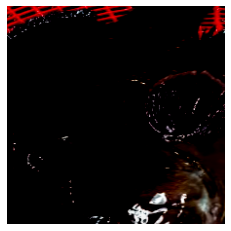

y: tensor([0, 0, 3, 3]), y.shape: torch.Size([4])
torch.Size([4, 3, 224, 224])


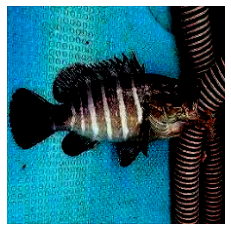

In [22]:
import os
import torch
import albumentations as A
from PIL import Image
from glob import glob
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class OceanDataset(Dataset):
    
    def __init__(self, args, transform, dataset, mode='train'):
        super().__init__()
        self.args = args
        self.transform = transform
        self.dataset = np.array(dataset['path'].values)
        self.y = np.array(dataset['label'].values, dtype=int)
        self.mode = mode
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        img = np.array(Image.open(self.dataset[index]))[:,:,:3]
            
        if self.transform:
            img = self.transform(image=img)['image']
        
        if self.mode == 'train':
            y = self.y[index]
            return img, y
        
        return img


def get_transform(args):
    train_transform = A.Compose([
        A.Resize(height=350, width=350),
        A.OneOf([
            A.CenterCrop(config.img_height, config.img_width),
            # A.RandomCrop(args['img_size'],args['img_size'])
        ],p=1),
        
        A.RGBShift(r_shift_limit=15, g_shift_limit=15,b_shift_limit=15,p=0.3),
        A.Blur(blur_limit=3, p=0.3),
        A.Affine(translate_px=30, shear=30, p=0.5),
        A.Rotate(limit=25, p=0.3),
        A.HorizontalFlip(),
        A.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
        ToTensorV2(),
    ])
    
    test_transform = A.Compose([
        A.Resize(height=config.img_height, width=config.img_width),
        A.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
        ToTensorV2(),
    ])
    return {
        'train': train_transform,
        'test': test_transform
    }

    
def get_loader(args, x_train, x_valid):
    train_transform = get_transform(config)['train']
    train_dataset = OceanDataset(config, train_transform, x_train)
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=config.batch_size,
                              shuffle=True,
                              num_workers=config.num_workers)
    
    val_transform = get_transform(config)['test']
    val_dataset = OceanDataset(config, val_transform, x_valid)
    val_loader = DataLoader(dataset=val_dataset,
                            batch_size=config.batch_size,
                            shuffle=False,
                            num_workers=config.num_workers)
    
    return {
        'train':train_loader, 
        'valid':val_loader
    }


if __name__ == '__main__':
    import matplotlib.pyplot as plt
    
    x_train, x_valid = train_test_split(train, 
                                        test_size=0.2, 
                                        shuffle=config.shuffle, 
                                        random_state=config.random_state, 
                                        stratify=train['label'])
    
    train_loader = get_loader(config, x_train, x_valid)['train']
    valid_loader = get_loader(config, x_train, x_valid)['valid']
    
    # train loader test
    for (img, y) in train_loader:
        print(f"y: {y}, y.shape: {y.shape}")
        print(f"y: {y}")
        print(img.shape)
        plt.imshow(img[0].permute(1,2,0))
        plt.axis('off')
        plt.show()
        
        break
    
    # valid loader test
    for (img, y) in valid_loader:
        print(f"y: {y}, y.shape: {y.shape}")
        print(img.shape)
        plt.imshow(img[0].permute(1,2,0))
        plt.axis('off')
        plt.show()
        break

In [9]:
import warnings
warnings.filterwarnings('ignore')


from torch import nn
from efficientnet_pytorch import EfficientNet
from sklearn.model_selection import StratifiedKFold
from torch.optim.swa_utils import AveragedModel, SWALR
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix


skf = StratifiedKFold(n_splits=config.n_splits, 
                      shuffle=config.shuffle, 
                      random_state=config.random_state)

for fold_idx,(train_idx, valid_idx) in enumerate(
    skf.split(train, train['label'])
):
    best_loss = np.Inf
    cnt = 0
    
    print(f"================== fold={fold_idx+1} start!!! ==================")
    x_train = train.iloc[train_idx]
    x_valid = train.iloc[valid_idx]
    train_loader = get_loader(config, x_train, x_valid)['train']
    valid_loader = get_loader(config, x_train, x_valid)['valid']
    model_name = f'efficientnet-b{config.num_efficientnet}'
    model = EfficientNet.from_pretrained(f'efficientnet-b{config.num_efficientnet}', num_classes=4)

    model.to(config.cuda)
    optimizer = torch.optim.AdamW(model.parameters(), config.lr)
    scaler = torch.cuda.amp.GradScaler()
    crit = torch.nn.CrossEntropyLoss()

    for epoch in range(config.epochs):
        print(f"------------- epoch={epoch+1} start!!! -------------")

        ######################################################
        # training loop
        ######################################################
        model.train()
        total_train_loss = []
        for idx, (img, y) in enumerate(tqdm(train_loader)):
            model.train()

            img = img.to(config.cuda)
            y = y.to(config.cuda)
            
            with torch.cuda.amp.autocast():
                y_pred = model(img)
                train_loss_val = crit(y_pred, y.long())
            
            optimizer.zero_grad()
            scaler.scale(train_loss_val).backward()
            scaler.step(optimizer)
            scaler.update()
            total_train_loss.append(train_loss_val.cpu().detach().numpy())

        ######################################################
        # evaluation loop
        ######################################################
        model.eval()
        total_val_loss = []    
        for (img, y) in tqdm(valid_loader):
            img = img.to(config.cuda)
            y = y.to(config.cuda)
            y_pred = model(img)
            eval_loss_val = crit(y_pred, y.long())
            total_val_loss.append(eval_loss_val.cpu().detach().numpy())
            
        print(f"[{epoch+1}/{config.epochs}] | train_loss = {np.mean(total_train_loss)} | val_loss={np.mean(total_val_loss)}")


        ######################################################
        # early stopping loop
        ######################################################
        if best_loss > np.mean(total_val_loss):
            best_loss = np.mean(total_val_loss)
            print(f"best_loss update!! | best_loss={best_loss}")
            torch.save(model.state_dict(),f'./{fold_idx}_{model_name}.pth')
            cnt = 0
        else:
            cnt += 1
            print(f"Don't improve loss [{cnt}/{config.patient}] | best_loss={best_loss} | val_loss={np.mean(total_val_loss)}")

        if cnt == config.patient:
            print(f"patient={cnt}...")
            print(f"val_loss={np.mean(total_val_loss)} | best_loss={best_loss}")
            break

    ######################################################
    # F1-score,precision, Recall, Accuracy 확인
    ######################################################
    f1, accuracy, recall, precision = 0, 0, 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        model.eval()
        for (img, y) in valid_loader:
            img = img.to(config.cuda)
            y = y.to(config.cuda)

            outputs = model(img)
            _, predicted = torch.max(outputs.data, 1)
            y_true += y.cpu().detach().numpy().tolist()
            y_pred += predicted.cpu().detach().numpy().tolist()

    # f1 = f1_score(y_true, y_pred)
    # precision = precision_score(y_true, y_pred)
    # recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    print(f'fold{fold_idx} => acc: {accuracy:.4f}')

    print(f"========================================================================\n")
    np.save(f'fold{fold_idx}_y_true.npy', np.array(y_true))
    np.save(f'fold{fold_idx}_y_pred.npy', np.array(y_pred))
    np.save(f'fold{fold_idx} train loss.npy', np.array(total_train_loss))
    np.save(f'fold{fold_idx} val loss.npy', np.array(total_val_loss))

================== fold=1 start!!! ==================


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth


  0%|          | 0.00/254M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b7
------------- epoch=1 start!!! -------------


100%|██████████| 37/37 [00:22<00:00,  1.65it/s]


[1/30] | train_loss = 1.0593163967132568 | val_loss=0.7837702035903931
best_loss update!! | best_loss=0.7837702035903931
------------- epoch=2 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.79it/s]


[2/30] | train_loss = 0.6101503968238831 | val_loss=0.541623055934906
best_loss update!! | best_loss=0.541623055934906
------------- epoch=3 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.83it/s]


[3/30] | train_loss = 0.44776424765586853 | val_loss=0.5014855265617371
best_loss update!! | best_loss=0.5014855265617371
------------- epoch=4 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.84it/s]


[4/30] | train_loss = 0.4319317042827606 | val_loss=0.4505634307861328
best_loss update!! | best_loss=0.4505634307861328
------------- epoch=5 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.77it/s]


[5/30] | train_loss = 0.40292665362358093 | val_loss=0.5025750994682312
Don't improve loss [1/5] | best_loss=0.4505634307861328 | val_loss=0.5025750994682312
------------- epoch=6 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.81it/s]


[6/30] | train_loss = 0.34451454877853394 | val_loss=0.4235093593597412
best_loss update!! | best_loss=0.4235093593597412
------------- epoch=7 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.86it/s]


[7/30] | train_loss = 0.3029220998287201 | val_loss=0.4573507010936737
Don't improve loss [1/5] | best_loss=0.4235093593597412 | val_loss=0.4573507010936737
------------- epoch=8 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.81it/s]


[8/30] | train_loss = 0.2554737627506256 | val_loss=0.34248086810112
best_loss update!! | best_loss=0.34248086810112
------------- epoch=9 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.80it/s]


[9/30] | train_loss = 0.15949048101902008 | val_loss=0.3473755121231079
Don't improve loss [1/5] | best_loss=0.34248086810112 | val_loss=0.3473755121231079
------------- epoch=10 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.85it/s]


[10/30] | train_loss = 0.22216404974460602 | val_loss=0.39091920852661133
Don't improve loss [2/5] | best_loss=0.34248086810112 | val_loss=0.39091920852661133
------------- epoch=11 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.85it/s]


[11/30] | train_loss = 0.1943136751651764 | val_loss=0.45832809805870056
Don't improve loss [3/5] | best_loss=0.34248086810112 | val_loss=0.45832809805870056
------------- epoch=12 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.81it/s]


[12/30] | train_loss = 0.18297365307807922 | val_loss=0.43328750133514404
Don't improve loss [4/5] | best_loss=0.34248086810112 | val_loss=0.43328750133514404
------------- epoch=13 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.78it/s]

[13/30] | train_loss = 0.16746950149536133 | val_loss=0.5195909738540649
Don't improve loss [5/5] | best_loss=0.34248086810112 | val_loss=0.5195909738540649
patient=5...
val_loss=0.5195909738540649 | best_loss=0.34248086810112


fold0 => acc: 0.8082

================== fold=2 start!!! ==================
Loaded pretrained weights for efficientnet-b7
------------- epoch=1 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.26it/s]


[1/30] | train_loss = 1.0970513820648193 | val_loss=0.7239954471588135
best_loss update!! | best_loss=0.7239954471588135
------------- epoch=2 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


[2/30] | train_loss = 0.6080511212348938 | val_loss=0.49652451276779175
best_loss update!! | best_loss=0.49652451276779175
------------- epoch=3 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.28it/s]


[3/30] | train_loss = 0.47982558608055115 | val_loss=0.39248019456863403
best_loss update!! | best_loss=0.39248019456863403
------------- epoch=4 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.28it/s]


[4/30] | train_loss = 0.42311200499534607 | val_loss=0.35637199878692627
best_loss update!! | best_loss=0.35637199878692627
------------- epoch=5 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.30it/s]


[5/30] | train_loss = 0.3320201635360718 | val_loss=0.34739241003990173
best_loss update!! | best_loss=0.34739241003990173
------------- epoch=6 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


[6/30] | train_loss = 0.3278696835041046 | val_loss=0.33091121912002563
best_loss update!! | best_loss=0.33091121912002563
------------- epoch=7 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.28it/s]


[7/30] | train_loss = 0.23909221589565277 | val_loss=0.33659297227859497
Don't improve loss [1/5] | best_loss=0.33091121912002563 | val_loss=0.33659297227859497
------------- epoch=8 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


[8/30] | train_loss = 0.23753246665000916 | val_loss=0.24382951855659485
best_loss update!! | best_loss=0.24382951855659485
------------- epoch=9 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.29it/s]


[9/30] | train_loss = 0.2356579452753067 | val_loss=0.25513797998428345
Don't improve loss [1/5] | best_loss=0.24382951855659485 | val_loss=0.25513797998428345
------------- epoch=10 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.25it/s]


[10/30] | train_loss = 0.18814395368099213 | val_loss=0.3858928680419922
Don't improve loss [2/5] | best_loss=0.24382951855659485 | val_loss=0.3858928680419922
------------- epoch=11 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.32it/s]


[11/30] | train_loss = 0.15617674589157104 | val_loss=0.3073166012763977
Don't improve loss [3/5] | best_loss=0.24382951855659485 | val_loss=0.3073166012763977
------------- epoch=12 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.23it/s]


[12/30] | train_loss = 0.1921008676290512 | val_loss=0.4309256672859192
Don't improve loss [4/5] | best_loss=0.24382951855659485 | val_loss=0.4309256672859192
------------- epoch=13 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.23it/s]

[13/30] | train_loss = 0.12786933779716492 | val_loss=0.3382072150707245
Don't improve loss [5/5] | best_loss=0.24382951855659485 | val_loss=0.3382072150707245
patient=5...
val_loss=0.3382072150707245 | best_loss=0.24382951855659485


fold1 => acc: 0.8562

================== fold=3 start!!! ==================
Loaded pretrained weights for efficientnet-b7
------------- epoch=1 start!!! -------------


100%|██████████| 37/37 [00:06<00:00,  6.08it/s]


[1/30] | train_loss = 1.0526816844940186 | val_loss=0.5831785202026367
best_loss update!! | best_loss=0.5831785202026367
------------- epoch=2 start!!! -------------


100%|██████████| 37/37 [00:06<00:00,  6.11it/s]


[2/30] | train_loss = 0.6050069332122803 | val_loss=0.38698357343673706
best_loss update!! | best_loss=0.38698357343673706
------------- epoch=3 start!!! -------------


100%|██████████| 37/37 [00:06<00:00,  6.10it/s]


[3/30] | train_loss = 0.47357746958732605 | val_loss=0.44419020414352417
Don't improve loss [1/5] | best_loss=0.38698357343673706 | val_loss=0.44419020414352417
------------- epoch=4 start!!! -------------


100%|██████████| 37/37 [00:06<00:00,  6.08it/s]


[4/30] | train_loss = 0.3749848008155823 | val_loss=0.3597291111946106
best_loss update!! | best_loss=0.3597291111946106
------------- epoch=5 start!!! -------------


100%|██████████| 37/37 [00:06<00:00,  6.09it/s]


[5/30] | train_loss = 0.34515056014060974 | val_loss=0.4351872503757477
Don't improve loss [1/5] | best_loss=0.3597291111946106 | val_loss=0.4351872503757477
------------- epoch=6 start!!! -------------


100%|██████████| 37/37 [00:06<00:00,  6.14it/s]


[6/30] | train_loss = 0.30239546298980713 | val_loss=0.3459220826625824
best_loss update!! | best_loss=0.3459220826625824
------------- epoch=7 start!!! -------------


100%|██████████| 37/37 [00:06<00:00,  6.16it/s]


[7/30] | train_loss = 0.29002630710601807 | val_loss=0.4672909677028656
Don't improve loss [1/5] | best_loss=0.3459220826625824 | val_loss=0.4672909677028656
------------- epoch=8 start!!! -------------


100%|██████████| 37/37 [00:06<00:00,  6.01it/s]


[8/30] | train_loss = 0.24824665486812592 | val_loss=0.43230554461479187
Don't improve loss [2/5] | best_loss=0.3459220826625824 | val_loss=0.43230554461479187
------------- epoch=9 start!!! -------------


100%|██████████| 37/37 [00:06<00:00,  6.12it/s]


[9/30] | train_loss = 0.21730947494506836 | val_loss=0.3042508065700531
best_loss update!! | best_loss=0.3042508065700531
------------- epoch=10 start!!! -------------


100%|██████████| 37/37 [00:06<00:00,  6.12it/s]


[10/30] | train_loss = 0.13923904299736023 | val_loss=0.32546690106391907
Don't improve loss [1/5] | best_loss=0.3042508065700531 | val_loss=0.32546690106391907
------------- epoch=11 start!!! -------------


100%|██████████| 37/37 [00:06<00:00,  6.06it/s]


[11/30] | train_loss = 0.17906531691551208 | val_loss=0.4149712026119232
Don't improve loss [2/5] | best_loss=0.3042508065700531 | val_loss=0.4149712026119232
------------- epoch=12 start!!! -------------


100%|██████████| 37/37 [00:06<00:00,  6.02it/s]


[12/30] | train_loss = 0.20728127658367157 | val_loss=0.3219048082828522
Don't improve loss [3/5] | best_loss=0.3042508065700531 | val_loss=0.3219048082828522
------------- epoch=13 start!!! -------------


100%|██████████| 37/37 [00:06<00:00,  6.08it/s]


[13/30] | train_loss = 0.1884705275297165 | val_loss=0.3863193094730377
Don't improve loss [4/5] | best_loss=0.3042508065700531 | val_loss=0.3863193094730377
------------- epoch=14 start!!! -------------


100%|██████████| 37/37 [00:06<00:00,  6.09it/s]

[14/30] | train_loss = 0.11336624622344971 | val_loss=0.41375333070755005
Don't improve loss [5/5] | best_loss=0.3042508065700531 | val_loss=0.41375333070755005
patient=5...
val_loss=0.41375333070755005 | best_loss=0.3042508065700531


fold2 => acc: 0.8630

================== fold=4 start!!! ==================
Loaded pretrained weights for efficientnet-b7
------------- epoch=1 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.33it/s]


[1/30] | train_loss = 1.025794506072998 | val_loss=0.7097490429878235
best_loss update!! | best_loss=0.7097490429878235
------------- epoch=2 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.39it/s]


[2/30] | train_loss = 0.6766175627708435 | val_loss=0.5609850883483887
best_loss update!! | best_loss=0.5609850883483887
------------- epoch=3 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.22it/s]


[3/30] | train_loss = 0.44384056329727173 | val_loss=0.5665386319160461
Don't improve loss [1/5] | best_loss=0.5609850883483887 | val_loss=0.5665386319160461
------------- epoch=4 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.39it/s]


[4/30] | train_loss = 0.38108929991722107 | val_loss=0.5426909327507019
best_loss update!! | best_loss=0.5426909327507019
------------- epoch=5 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.45it/s]


[5/30] | train_loss = 0.3900488615036011 | val_loss=0.4706536829471588
best_loss update!! | best_loss=0.4706536829471588
------------- epoch=6 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.39it/s]


[6/30] | train_loss = 0.27702832221984863 | val_loss=0.4523904025554657
best_loss update!! | best_loss=0.4523904025554657
------------- epoch=7 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.40it/s]


[7/30] | train_loss = 0.224541574716568 | val_loss=0.381175696849823
best_loss update!! | best_loss=0.381175696849823
------------- epoch=8 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.44it/s]


[8/30] | train_loss = 0.27917182445526123 | val_loss=0.45817092061042786
Don't improve loss [1/5] | best_loss=0.381175696849823 | val_loss=0.45817092061042786
------------- epoch=9 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


[9/30] | train_loss = 0.23577292263507843 | val_loss=0.5078144669532776
Don't improve loss [2/5] | best_loss=0.381175696849823 | val_loss=0.5078144669532776
------------- epoch=10 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.40it/s]


[10/30] | train_loss = 0.23175542056560516 | val_loss=0.4303317368030548
Don't improve loss [3/5] | best_loss=0.381175696849823 | val_loss=0.4303317368030548
------------- epoch=11 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.42it/s]


[11/30] | train_loss = 0.14358606934547424 | val_loss=0.4255876839160919
Don't improve loss [4/5] | best_loss=0.381175696849823 | val_loss=0.4255876839160919
------------- epoch=12 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.31it/s]


[12/30] | train_loss = 0.18188056349754333 | val_loss=0.348102867603302
best_loss update!! | best_loss=0.348102867603302
------------- epoch=13 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.40it/s]


[13/30] | train_loss = 0.10605571419000626 | val_loss=0.4930330812931061
Don't improve loss [1/5] | best_loss=0.348102867603302 | val_loss=0.4930330812931061
------------- epoch=14 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.46it/s]


[14/30] | train_loss = 0.08205972611904144 | val_loss=0.45273977518081665
Don't improve loss [2/5] | best_loss=0.348102867603302 | val_loss=0.45273977518081665
------------- epoch=15 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.41it/s]


[15/30] | train_loss = 0.14025264978408813 | val_loss=0.47384557127952576
Don't improve loss [3/5] | best_loss=0.348102867603302 | val_loss=0.47384557127952576
------------- epoch=16 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.41it/s]


[16/30] | train_loss = 0.11659112572669983 | val_loss=0.5843668580055237
Don't improve loss [4/5] | best_loss=0.348102867603302 | val_loss=0.5843668580055237
------------- epoch=17 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.41it/s]

[17/30] | train_loss = 0.1529088169336319 | val_loss=0.5372224450111389
Don't improve loss [5/5] | best_loss=0.348102867603302 | val_loss=0.5372224450111389
patient=5...
val_loss=0.5372224450111389 | best_loss=0.348102867603302


fold3 => acc: 0.8483

================== fold=5 start!!! ==================
Loaded pretrained weights for efficientnet-b7
------------- epoch=1 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.43it/s]


[1/30] | train_loss = 1.0533849000930786 | val_loss=0.7730425000190735
best_loss update!! | best_loss=0.7730425000190735
------------- epoch=2 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.53it/s]


[2/30] | train_loss = 0.6818166971206665 | val_loss=0.5401902794837952
best_loss update!! | best_loss=0.5401902794837952
------------- epoch=3 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.42it/s]


[3/30] | train_loss = 0.528130292892456 | val_loss=0.5534487366676331
Don't improve loss [1/5] | best_loss=0.5401902794837952 | val_loss=0.5534487366676331
------------- epoch=4 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.56it/s]


[4/30] | train_loss = 0.3986029028892517 | val_loss=0.46066468954086304
best_loss update!! | best_loss=0.46066468954086304
------------- epoch=5 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.55it/s]


[5/30] | train_loss = 0.3387854993343353 | val_loss=0.5134668350219727
Don't improve loss [1/5] | best_loss=0.46066468954086304 | val_loss=0.5134668350219727
------------- epoch=6 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.53it/s]


[6/30] | train_loss = 0.2576161324977875 | val_loss=0.43913698196411133
best_loss update!! | best_loss=0.43913698196411133
------------- epoch=7 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.60it/s]


[7/30] | train_loss = 0.27581581473350525 | val_loss=0.5290517807006836
Don't improve loss [1/5] | best_loss=0.43913698196411133 | val_loss=0.5290517807006836
------------- epoch=8 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.55it/s]


[8/30] | train_loss = 0.21552705764770508 | val_loss=0.40890729427337646
best_loss update!! | best_loss=0.40890729427337646
------------- epoch=9 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.54it/s]


[9/30] | train_loss = 0.2788807153701782 | val_loss=0.42637792229652405
Don't improve loss [1/5] | best_loss=0.40890729427337646 | val_loss=0.42637792229652405
------------- epoch=10 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.57it/s]


[10/30] | train_loss = 0.17663505673408508 | val_loss=0.49291983246803284
Don't improve loss [2/5] | best_loss=0.40890729427337646 | val_loss=0.49291983246803284
------------- epoch=11 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.54it/s]


[11/30] | train_loss = 0.1516733020544052 | val_loss=0.4180935025215149
Don't improve loss [3/5] | best_loss=0.40890729427337646 | val_loss=0.4180935025215149
------------- epoch=12 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.49it/s]


[12/30] | train_loss = 0.14509384334087372 | val_loss=0.2711702287197113
best_loss update!! | best_loss=0.2711702287197113
------------- epoch=13 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.53it/s]


[13/30] | train_loss = 0.1881444752216339 | val_loss=0.4655199944972992
Don't improve loss [1/5] | best_loss=0.2711702287197113 | val_loss=0.4655199944972992
------------- epoch=14 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.52it/s]


[14/30] | train_loss = 0.14891891181468964 | val_loss=0.709947943687439
Don't improve loss [2/5] | best_loss=0.2711702287197113 | val_loss=0.709947943687439
------------- epoch=15 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.47it/s]


[15/30] | train_loss = 0.0670572817325592 | val_loss=0.48790082335472107
Don't improve loss [3/5] | best_loss=0.2711702287197113 | val_loss=0.48790082335472107
------------- epoch=16 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.44it/s]


[16/30] | train_loss = 0.12401136755943298 | val_loss=0.4605294167995453
Don't improve loss [4/5] | best_loss=0.2711702287197113 | val_loss=0.4605294167995453
------------- epoch=17 start!!! -------------


100%|██████████| 37/37 [00:05<00:00,  6.55it/s]

[17/30] | train_loss = 0.12885840237140656 | val_loss=0.5197432041168213
Don't improve loss [5/5] | best_loss=0.2711702287197113 | val_loss=0.5197432041168213
patient=5...
val_loss=0.5197432041168213 | best_loss=0.2711702287197113


fold4 => acc: 0.8345



# test 데이터 Infererence

In [11]:
def test_get_loader(args, x_train, x_valid):
    train_transform = get_transform(config)['train']
    train_dataset = OceanDataset(config, train_transform, x_train)
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=1,
                              shuffle=True,
                              num_workers=config.num_workers,
                              drop_last=True)
    
    val_transform = get_transform(config)['test']
    val_dataset = OceanDataset(config, val_transform, x_valid)
    val_loader = DataLoader(dataset=val_dataset,
                            batch_size=1,
                            shuffle=False,
                            num_workers=config.num_workers,
                            drop_last=True)
    
    return {
        'train':train_loader, 
        'valid':val_loader
    }

x_train, x_valid = train_test_split(train, 
                                    test_size=0.2, 
                                    shuffle=config.shuffle, 
                                    random_state=config.random_state, 
                                    stratify=train['label'])
    

train_loader = test_get_loader(config, x_train, x_valid)['train']
valid_loader = test_get_loader(config, x_train, x_valid)['valid']

In [27]:
import os

os.makedir('valid_class4', exist_ok=True)

model = EfficientNet.from_pretrained(model_name, num_classes=4)
model.load_state_dict(torch.load('/content/1_efficientnet-b7.pth'))
model.to(config.cuda)

f1, accuracy, recall, precision = 0, 0, 0, 0
y_true, y_pred = [], []
with torch.no_grad():
    model.eval()
    for batch_id, (img, y) in enumerate(valid_loader):

        # print(img.shape)
        for i in range(1):
            # img_s = img[i] * 256
            # img_s = img_s.clip(0, 255)
          plt.imshow(img[i].permute(1,2,0))
          plt.axis('off')
          plt.savefig(f'valid_class4/{batch_id}',dpi=300)
        img = img.to(config.cuda)
        y = y.to(config.cuda)
        outputs = model(img)
        _, predicted = torch.max(outputs.data, 1)
        y_true += y.cpu().detach().numpy().tolist()
        y_pred += predicted.cpu().detach().numpy().tolist()

NameError: ignored

In [ ]:
print('잘못 분류한 이미지')
for i in range(len(y_true)):
  if y_pred[i] != y_true[i]:
    # print(f'{i//config.batch_size}_{i%config.batch_size} ')
    print(f'{i} 정답: {y_true[i]}, 예측: {y_pred[i]}')

# 0: 능성어, 1: 자바리

# 능성어 = 0
# 유사어종 외 = 1
# 유사어종 = 2
# 자바리  = 3
print(f'정답 레이블 : {y_true}')
print(f'예측 레이블 : {y_pred}')

In [ ]:
!zip -r /content/valid_class4.zip /content/valid_class4

# confusion matrix 시각화

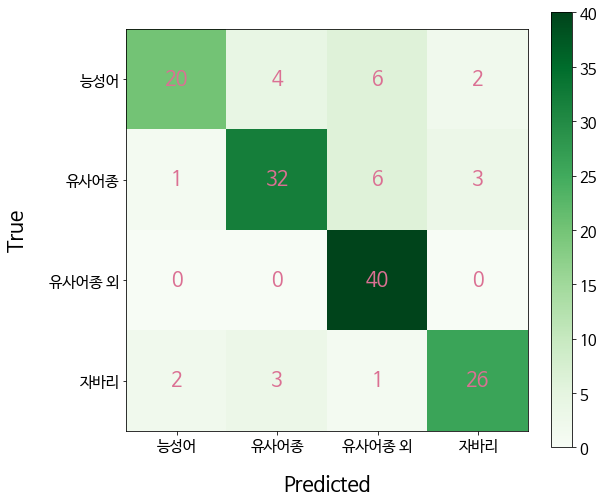

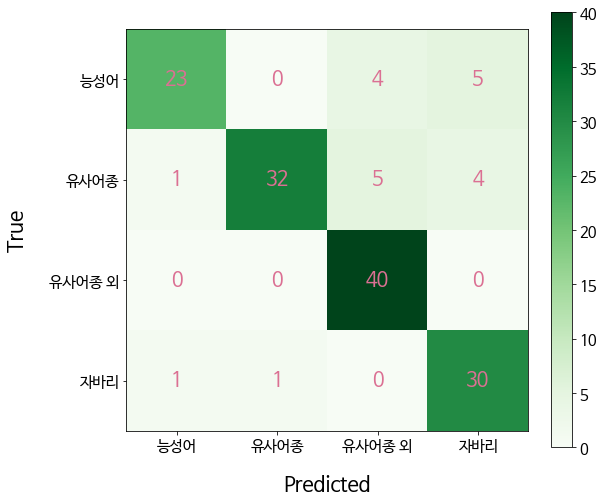

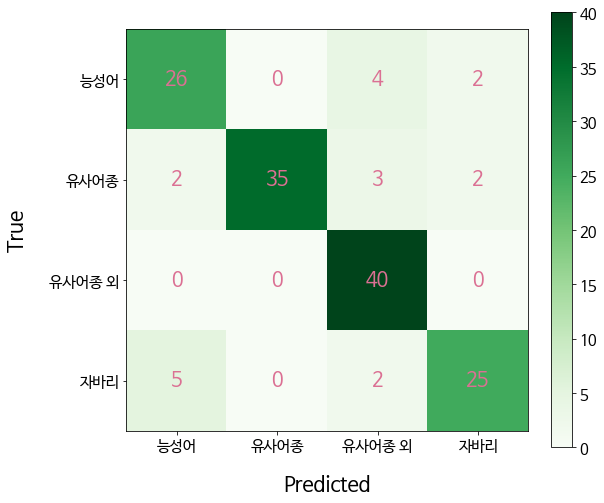

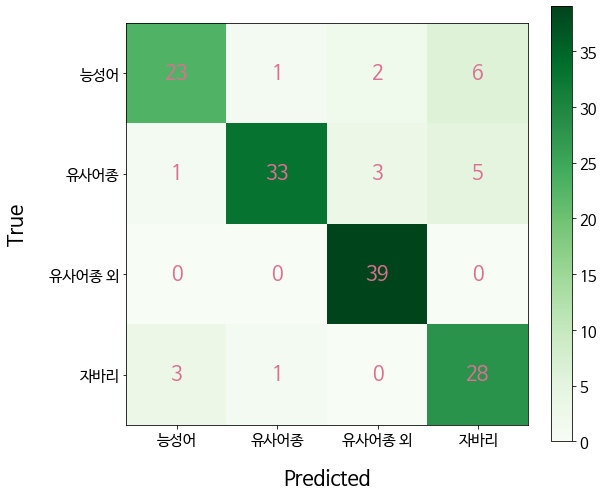

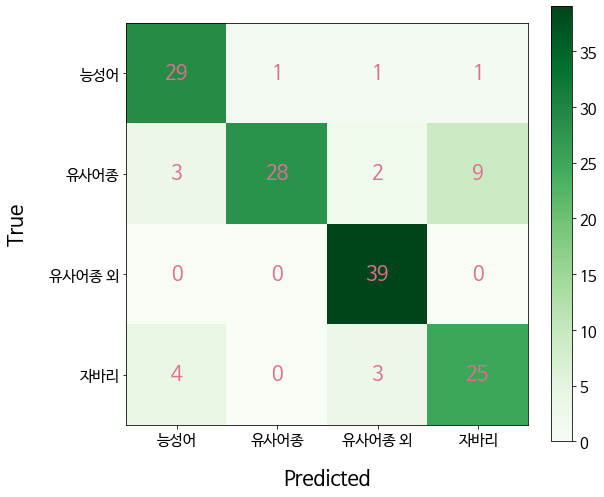

In [63]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix


for fold_id in range(5):
  y_true = np.load(f'fold{fold_id}_y_true.npy')
  y_pred = np.load(f'fold{fold_id}_y_pred.npy')
  plt.rcParams['font.family'] = 'NanumGothic'
  plt.rcParams['font.family'] = 'Malgun Gothic'
  plt.rcParams['font.size'] = 15

  plt.rc('font', family='NanumBarunGothic') 
  conf_matrix = confusion_matrix(y_true, y_pred)

  cmap=cmap=plt.cm.Greens
  plt.figure(figsize=(8, 8))
  plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
  plt.colorbar(fraction=0.05, pad=0.05)
  tick_marks = np.arange(4, 4)
  plt.xticks(np.arange(4), ('능성어', '유사어종','유사어종 외','자바리'))
  plt.yticks(np.arange(4), ('능성어', '유사어종','유사어종 외', '자바리'))
  fmt = 'd' 
  thresh = 1
  for i in range(4):
      for j in range(4):
          plt.text(j, i, format(conf_matrix[i][j], fmt),color='palevioletred',
                  fontsize=20,
                  ha="center", va="center")
  plt.ylabel('True', fontsize=20, labelpad=20)
  plt.xlabel('Predicted', fontsize=20, labelpad=20)


# 주어진 5개 테스트 데이터 예측

In [53]:
test = glob(f'/content/drive/MyDrive/해양/테스트 데이터/*')
test_df = pd.DataFrame({
    'path':test
})
test_df

,path
0,/content/drive/MyDrive/해양/테스트 데이터/unknown3.png
1,/content/drive/MyDrive/해양/테스트 데이터/unknown4.png
2,/content/drive/MyDrive/해양/테스트 데이터/unknown2.png
3,/content/drive/MyDrive/해양/테스트 데이터/unknown.png
4,/content/drive/MyDrive/해양/테스트 데이터/unknown1.png
5,/content/drive/MyDrive/해양/테스트 데이터/unknown5.png


In [56]:
class TestOceanDataset(Dataset):
    
    def __init__(self, args, transform, dataset):
        super().__init__()
        self.args = args
        self.transform = transform
        self.dataset = np.array(dataset['path'].values)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        img = np.array(Image.open(self.dataset[index]))[:,:,:3]
            
        if self.transform:
            img = self.transform(image=img)['image']
        
        return img


val_transform = get_transform(config)['test']
val_dataset = TestOceanDataset(config, val_transform, test_df)
test_loader = DataLoader(dataset=val_dataset,
                        batch_size=1,
                        shuffle=False,
                        num_workers=config.num_workers)

In [64]:
from torch import nn
from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=4)
model.load_state_dict(torch.load('/content/1_efficientnet-b7.pth'))
model.to(config.cuda)

y_pred = [], []
softmax = nn.Softmax(dim=1)
with torch.no_grad():
    model.eval()
    for batch_id, img in enumerate(test_loader):
        img = img.to(config.cuda)

        outputs = model(img)
        _, predicted = torch.max(outputs.data, 1)
        y_pred += predicted.cpu().detach().numpy()

        # 각 class별 예측한 확률
        print(softmax(outputs))

Loaded pretrained weights for efficientnet-b7
tensor([[3.5404e-02, 7.3143e-05, 2.0565e-02, 9.4396e-01]], device='cuda:0')
tensor([[0.4200, 0.0383, 0.0188, 0.5229]], device='cuda:0')
tensor([[9.4280e-01, 1.4798e-02, 5.7997e-04, 4.1824e-02]], device='cuda:0')
tensor([[0.0528, 0.9055, 0.0077, 0.0340]], device='cuda:0')
tensor([[8.6001e-01, 2.4495e-02, 1.8964e-04, 1.1530e-01]], device='cuda:0')
tensor([[0.8600, 0.0919, 0.0155, 0.0326]], device='cuda:0')


In [61]:
y_pred

[3, 3, 0, 1, 0, 0]